In [ ]:
# Importing libraries

import warnings
warnings.filterwarnings('ignore')

import time
t = time.time()

print(f'Importing started....\n')

# Import base libraries
import os
import numpy as np
import pandas as pd
import re
from scipy import stats
from random import randint
from datetime import datetime

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px


from sklearn.model_selection import (TimeSeriesSplit,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     train_test_split,
                                     KFold,
                                     StratifiedKFold,
                                    cross_val_score)

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder)

from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel

# Importing required metrics
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             mean_absolute_error)

from sklearn.metrics import make_scorer

# Modeling algorithms
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor,
                              RandomForestRegressor,
                              VotingRegressor,
                              GradientBoostingRegressor)
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import (LGBMRegressor,
                      early_stopping)

# sklearn base models for stacked ensemble model
from sklearn.pipeline import make_pipeline

print(f'Done! All required libraries have been imported. Time elapsed: {time.time() - t }sec')


Importing started....

Done! All required libraries have been imported. Time elapsed: 6.336275577545166sec


**Getting To Know More About The Data**

In [ ]:
# Importing the data
df = pd.read_csv('Walmart.csv', parse_dates=['Date'])

# Read the first 5 rows of data
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
# Number of rows and number of columns in df
df.shape

(6435, 8)

In [ ]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [ ]:
# Finding unique values for columns 'Store', 'Fuel_Price' and 'Unemployment'

for i in ['Store', 'Fuel_Price', 'Unemployment']:
  print(f'{i}: {df[i].nunique()}')

Store: 45
Fuel_Price: 892
Unemployment: 349


There are 45 unique stores, 892 fuel_prices, and 349 unique values of unemployment.

In [ ]:
# Getting the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


Exploratory Data Analysis (EDA)

In [ ]:
# Correlating the Temperature and the Weekly Sales

fig = px.histogram(df, x='Temperature', y ='Weekly_Sales', color='Holiday_Flag')
fig.show()

In [ ]:
# Correlating Unemployment and Weekly Sales
fig = px.histogram(df, x='Unemployment', y ='Weekly_Sales')
fig.show()

In [ ]:
# Correlating how Unemployment affect Weekly Sales
fig = px.histogram(df, x='Unemployment', y ='Weekly_Sales', marginal = 'box', title = 'How Unemployment affect sales', template = 'simple_white')
fig.show()

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

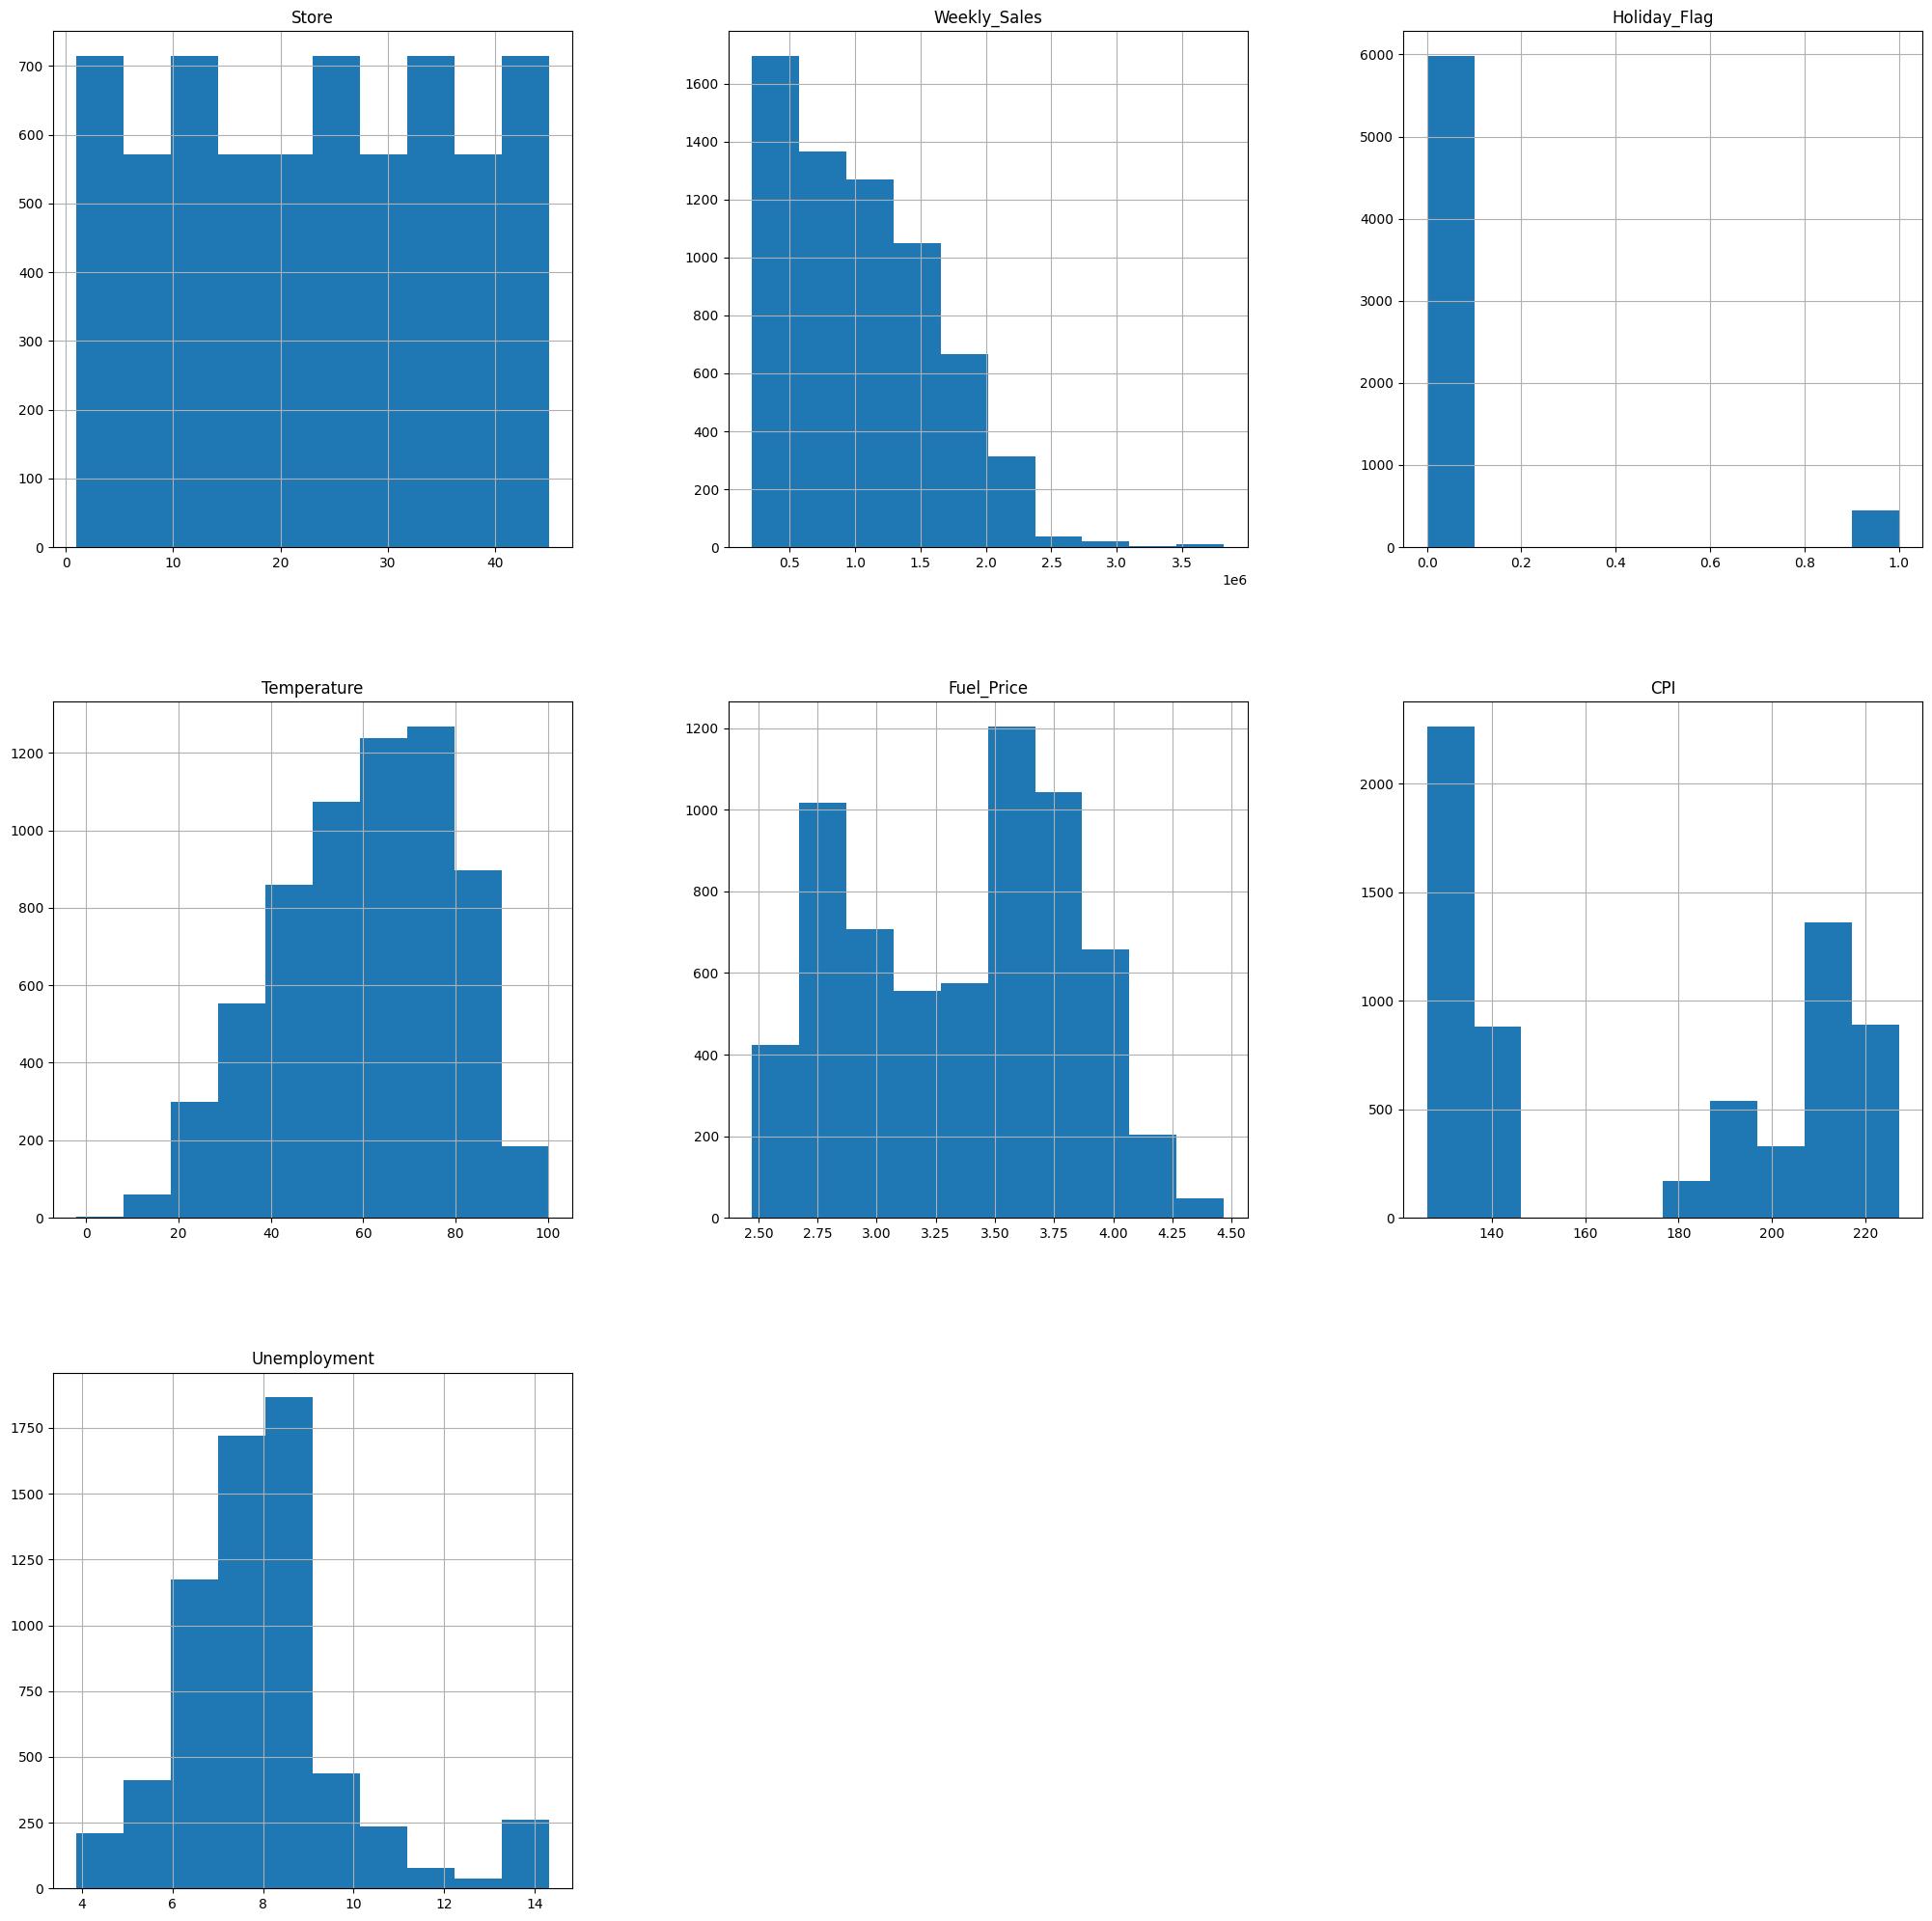

In [ ]:
# Creates a histogram of the Dataframe df, displaying the distribution of input features

fig = plt.figure(figsize=(25,25))  # 25" wide x 25" tall
ax = fig.gca()
df.hist(ax=ax)
plt.tight_layout

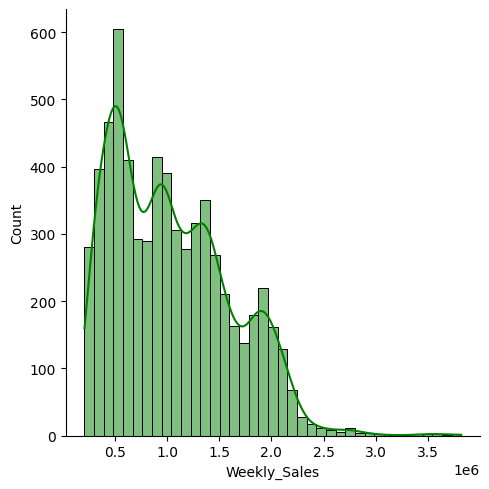

In [ ]:
# Visualize the distribution of data
sns.displot(df['Weekly_Sales'], kde=True, color='green')

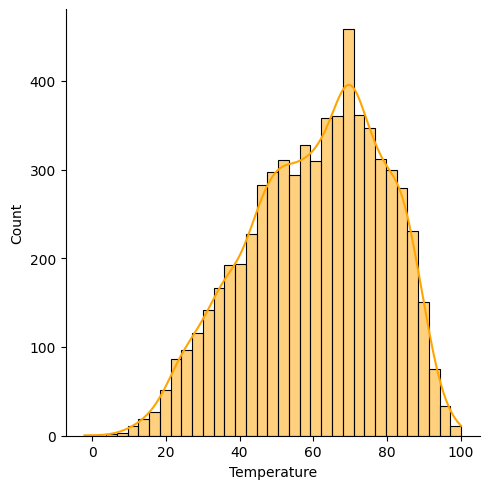

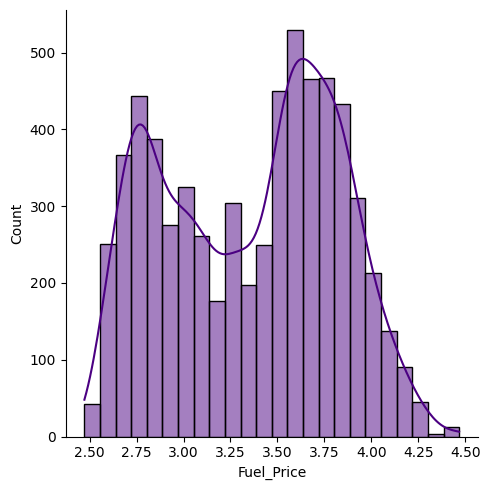

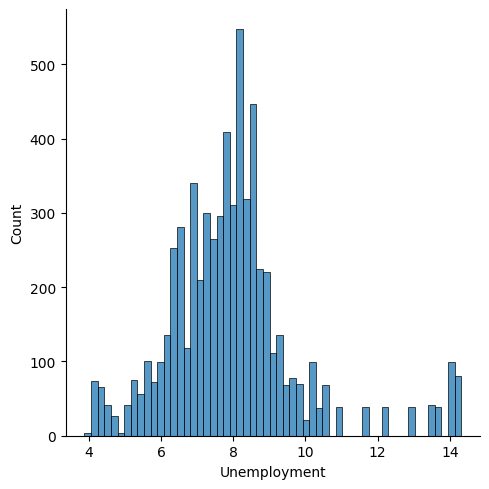

In [ ]:
sns.displot(df['Temperature'], kde=True, color='orange')
sns.displot(df['Fuel_Price'], kde=True, color='indigo')
sns.displot(df['Unemployment'], kde=False)

Doing Analysis using TIMESERIES factor

In [ ]:
# Note: Once you set parse_dates=['Date'] in read_csv, the 'Date' would be parsed in YYYY-MM-DD format

# Convert valid dates to datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce')

# Replace the NaT values in the 'Date' column with a specific date
df['Date'] = df['Date'].fillna(df['Date'].min())


# Extract the 'Year', 'Month', 'Day' and 'WeekOfYear' columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week


In [ ]:


# Map the 'Day' and 'Month' columns

days = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
df['Day'] = df['Date'].dt.day_name()
months={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
df['Month']= df['Date'].dt.month_name()


'''
days = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
df['Day'] = df['Day'].apply(lambda x: days[datetime.strptime(f'2024-{x}-01', '%Y-%m-%d').weekday()])
months={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
df['Month']= df['Month'].apply(lambda x: months[int(x)])
'''

# Display the updated DataFrame
# df['Date'] = df['Date'].astype(str)  # Convert the 'Date' column to string
df.head(10)




,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,WeekOfYear
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,2010,May,Sunday,17
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2010,December,Thursday,48
2,1,2010-01-10,1611968.17,0,39.93,2.514,211.289143,8.106,2010,January,Sunday,1
3,1,2010-01-10,1409727.59,0,46.63,2.561,211.319643,8.106,2010,January,Sunday,1
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,2010,May,Monday,18
5,1,2010-12-03,1439541.59,0,57.79,2.667,211.380643,8.106,2010,December,Friday,48
6,1,2010-01-10,1472515.79,0,54.58,2.720,211.215635,8.106,2010,January,Sunday,1
7,1,2010-01-10,1404429.92,0,51.45,2.732,211.018042,8.106,2010,January,Sunday,1
8,1,2010-02-04,1594968.28,0,62.27,2.719,210.820450,7.808,2010,February,Thursday,5
9,1,2010-09-04,1545418.53,0,65.86,2.770,210.622857,7.808,2010,September,Saturday,35


<Axes: xlabel='Year', ylabel='count'>

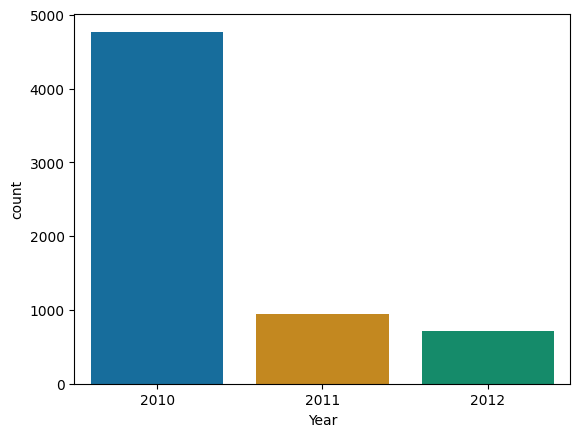

In [ ]:
# Show the counts of observation in each category bin using bars.

sns.countplot(x=df['Year'],order=df['Year'].value_counts().index, orient='index', palette='colorblind')

<Axes: xlabel='Day', ylabel='count'>

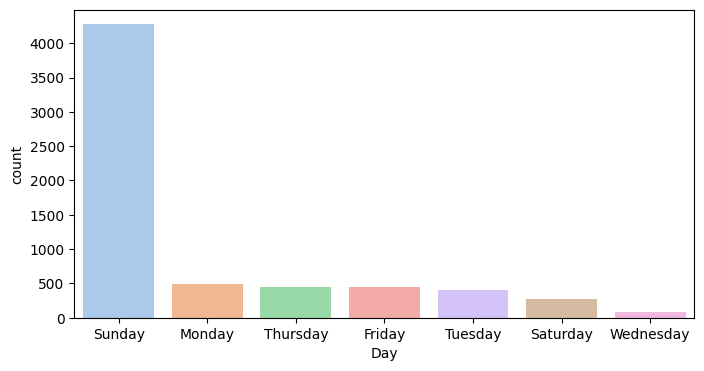

In [ ]:

plt.figure(figsize=(8,4))
sns.countplot(x= df['Day'],order=df['Day'].value_counts().index, orient='index', palette='pastel')

<Axes: xlabel='Month', ylabel='count'>

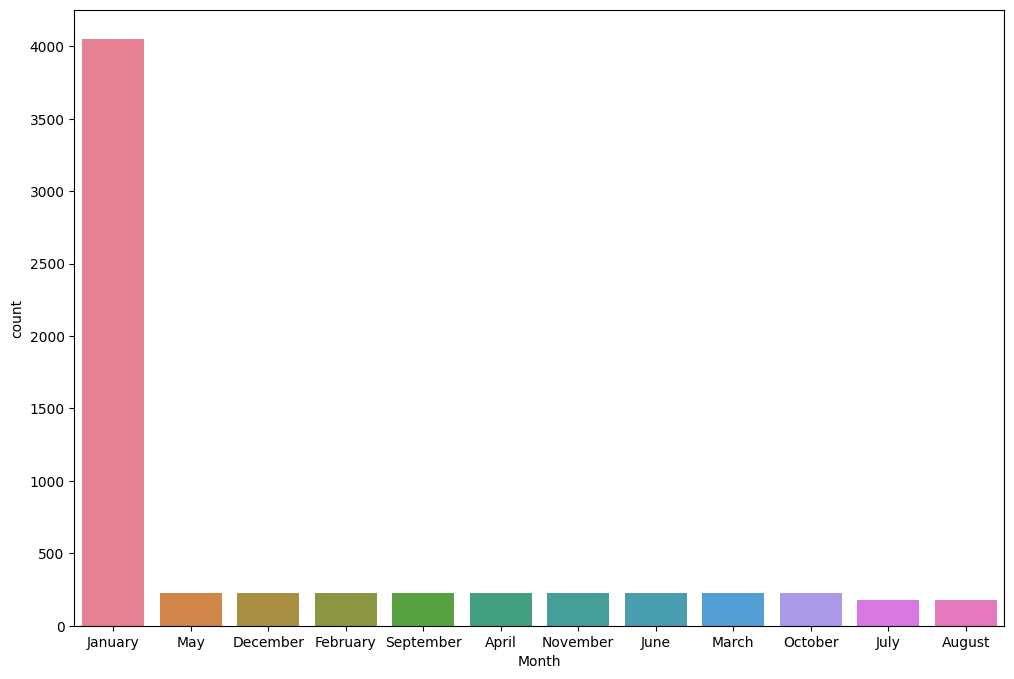

In [ ]:
plt.figure(figsize=(12,8))

sns.countplot(x=df['Month'], order=df['Month'].value_counts().index, orient='index', palette='husl')


Text(0.5, 1.0, 'Annual Sales')

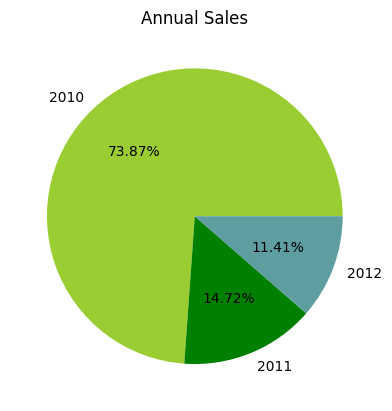

In [ ]:
# Creating a pie chart using matplotlib library to visualize the annual sales data from the DataFrame df for the years 2010, 2011 and 2012.
plt.pie(df.groupby('Year')['Weekly_Sales'].sum(), labels=df['Year'].unique(), normalize=True, autopct='%1.2f%%', colors=['yellowgreen', 'green', 'cadetblue'])
plt.title('Annual Sales')

([<matplotlib.patches.Wedge at 0x7bda54b2b3d0>,
 [Text(1.0739536399765555, 0.23795709525270964, 'Friday'),
  Text(0.8501597361913306, 0.6980174947371215, 'Monday'),
  Text(0.5276412532475079, 0.9651915394735904, 'Saturday'),
  Text(-1.0902137094154345, -0.14640378343007024, 'Sunday'),
  Text(0.8320368042989098, -0.7195239789555715, 'Thursday'),
  Text(1.0545042156016053, -0.31308283133771997, 'Tuesday'),
  Text(1.0989722004922018, -0.04754053581237958, 'Wednesday')],
 [Text(0.5857928945326666, 0.12979477922875068, '6.94%'),
  Text(0.4637234924679984, 0.3807368153111571, '8.00%'),
  Text(0.2878043199531861, 0.5264681124401401, '4.19%'),
  Text(-0.5946620233175096, -0.07985660914367466, '65.98%'),
  Text(0.4538382568903144, -0.39246762488485715, '7.07%'),
  Text(0.5751841176008756, -0.17077245345693814, '6.43%'),
  Text(0.5994393820866554, -0.025931201352207042, '1.38%')])

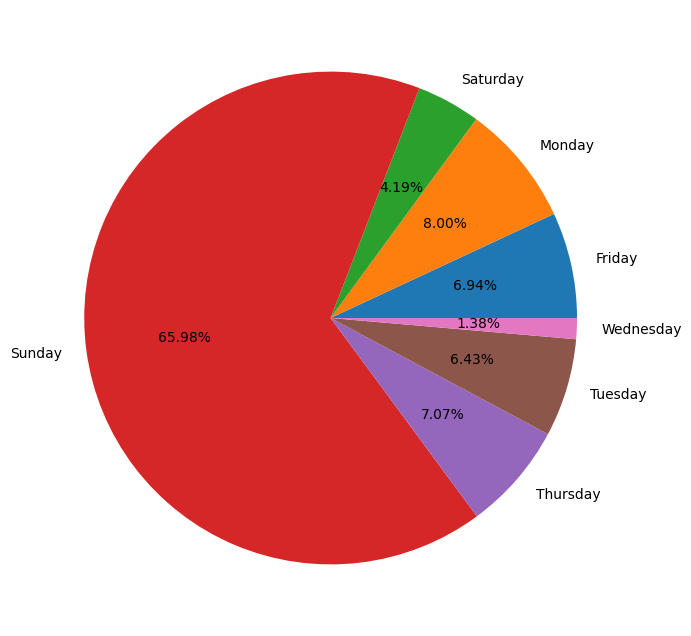

In [ ]:
# Creating a pie chart to visualize the weekly sales data by days of the week.
df2 = df.groupby('Day')['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(10,8))
plt.pie(df2['Weekly_Sales'], labels = df2['Day'], autopct='%1.2f%%', normalize=True)

([<matplotlib.patches.Wedge at 0x7bda54bc0f10>,
 [Text(1.0931700498201908, 0.12238971433957056, 'April'),
  Text(1.0472688069954725, 0.3364937531281673, 'August'),
  Text(0.9614518970359363, 0.5344251581709076, 'December'),
  Text(0.8209893264638187, 0.7321041768986745, 'February'),
  Text(-1.0361376406689375, 0.3693491432087096, 'January'),
  Text(0.14528876816311842, -1.0903628633833984, 'July'),
  Text(0.3603201302736209, -1.0393119857480722, 'June'),
  Text(0.5838571883402043, -0.9322611134352174, 'March'),
  Text(0.7752859185213455, -0.780340787440022, 'May'),
  Text(0.9272743642200953, -0.5917450916232581, 'November'),
  Text(1.035760753905068, -0.3704047254963215, 'October'),
  Text(1.0928252507736176, -0.1254311415541611, 'September')],
 [Text(0.5962745726291949, 0.06675802600340211, '3.55%'),
  Text(0.5712375310884394, 0.18354204716081854, '2.80%'),
  Text(0.5244283074741469, 0.2915046317295859, '3.45%'),
  Text(0.44781235988935564, 0.39932955103564055, '3.58%'),
  Text(-0.565

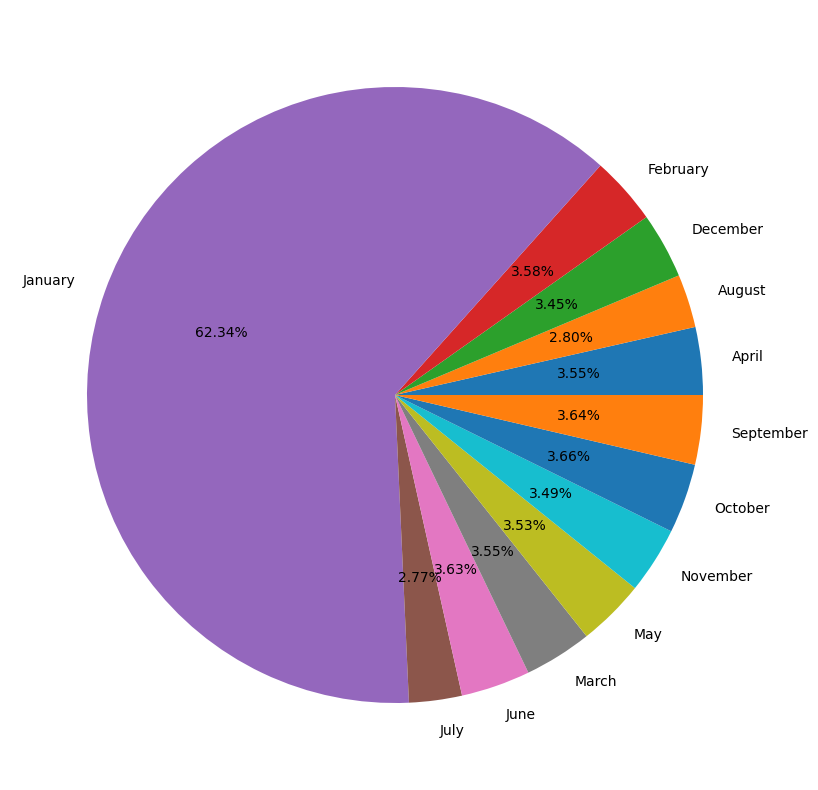

In [ ]:
plt.figure(figsize=(10,10))
df3 = df.groupby('Month')['Weekly_Sales'].sum().reset_index()
plt.pie(df3['Weekly_Sales'], labels=df3['Month'], autopct='%1.2f%%', normalize=True)

([<matplotlib.patches.Wedge at 0x7bda54a55e70>,
 [Text(-0.25679386593526243, -1.0696059603508306, 'Non Special Holiday Week'),
  Text(0.3268284610531304, 1.361316699760068, 'Special Holiday Week')],
 [Text(-0.14006938141923403, -0.5834214329186348, '92.50%'),
  Text(0.2101040106770124, 0.8751321641314721, '7.50%')])

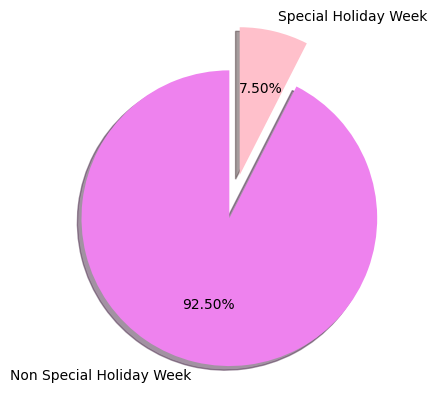

In [ ]:
df4 = df.groupby('Holiday_Flag')['Weekly_Sales'].sum().reset_index()
plt.pie(df4['Weekly_Sales'], labels=['Non Special Holiday Week', 'Special Holiday Week'], normalize=True, autopct='%1.2f%%',startangle=90,explode=[0,0.3],shadow=True,colors=['violet','pink'])

In [ ]:
fig = px.histogram(df, x='WeekOfYear', y='Weekly_Sales')
fig.show()

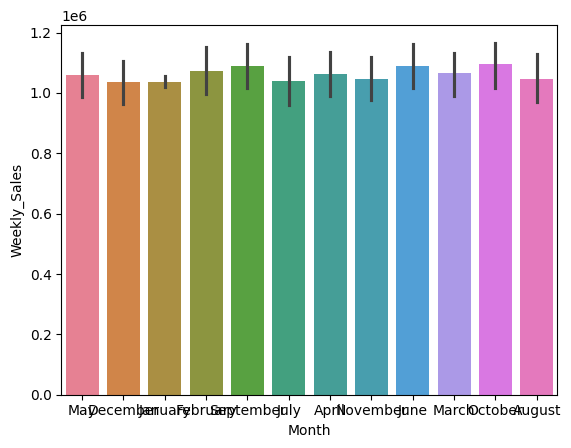

In [ ]:
# Plotting bar chart to visualize the weekly sales for all 12 months in a year
# sns.barplot(df['Month'], df['Weekly_Sales'])
sns.barplot(x='Month', y='Weekly_Sales', data=df, palette='husl')
plt.show()

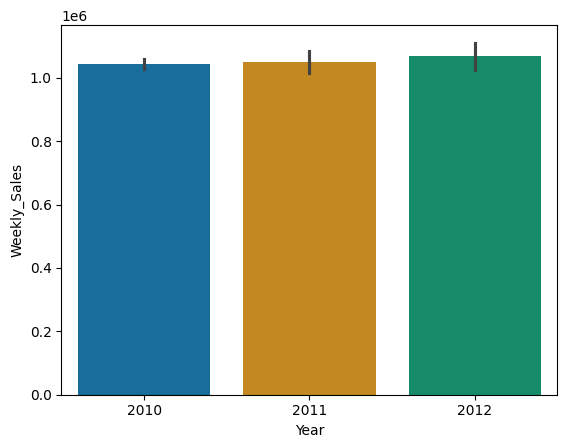

In [ ]:
sns.barplot(x='Year', y='Weekly_Sales', data=df, palette='colorblind')
plt.show()

**DATA PROCESSING FOR MODEL FIT**

In [ ]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

Text(0.5, 1.0, 'Correlation Matrix')

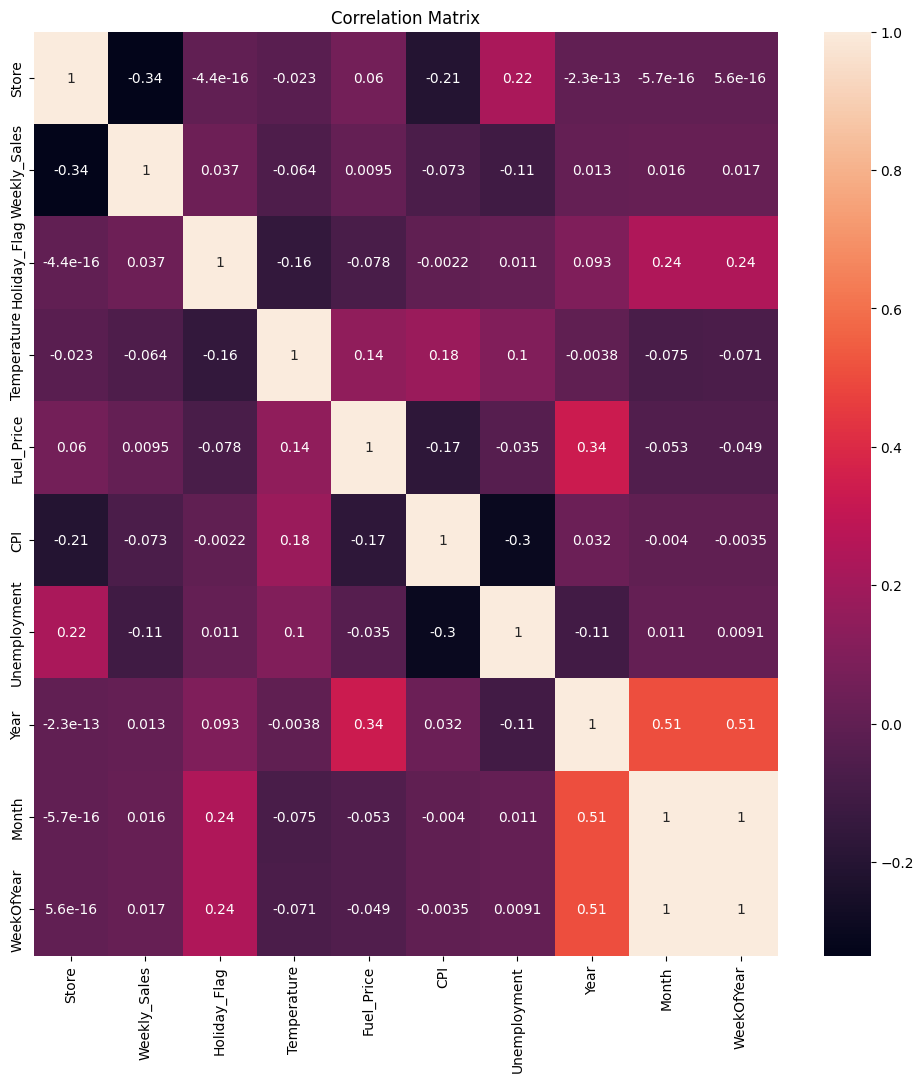

In [ ]:
# df['Month'] = df['Month'].astype('category').cat.codes
# df['Month'] = df['Month'].apply(lambda x:{'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May':5, 'June': 6, 'July': 7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}[x])
# df['Month'] = df['Month'].astype(float)
#df['Month'] = df['Month'].astype('category')
#df['Month'] = df['Month'].cat.codes

#df['Month'] = df['Month'].replace('Sunday', np.nan)

# df['Month'] = pd.to_numeric(df['Month'])


# df['Month'] = df['Month'].apply(lambda x:{'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May':5, 'June': 6, 'July': 7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}.get(x, x))

'''
def is_valid_month(month):
  valid_months = {'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'}
  return month in valid_months
'''


# df['Month'] = df[df['Month'].apply(is_valid_month)]['Month'].apply(lambda x:{'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May':5, 'June': 6, 'July': 7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}[x])


# There ar NaN values in the 'Month' column, and these NaN values are not found in the dictionary I am using
# to map the month names to numbers. Adding a condition to handle the NaN values before applying the lambda
# function. The .get(x) function will return NaN if the value of x is not found in the dictionary
df['Month'] = df['Month'].apply(lambda x: {None: np.nan, 'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May':5, 'June': 6, 'July': 7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}.get(x, np.nan))


plt.figure(figsize=(12,12))
numerical_df = df.select_dtypes(include=[np.number])
sns.heatmap(numerical_df.corr(), annot=True)
plt.title('Correlation Matrix')

In [ ]:
# Dropping 'Weekly_Sales' and 'Date' columns
X = df.drop(['Weekly_Sales', 'Date'], axis=1)
Y = df['Weekly_Sales']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Holiday_Flag  6435 non-null   int64  
 2   Temperature   6435 non-null   float64
 3   Fuel_Price    6435 non-null   float64
 4   CPI           6435 non-null   float64
 5   Unemployment  6435 non-null   float64
 6   Year          6435 non-null   int32  
 7   Month         6435 non-null   object 
 8   Day           6435 non-null   object 
 9   WeekOfYear    6435 non-null   UInt32 
dtypes: UInt32(1), float64(4), int32(1), int64(2), object(2)
memory usage: 458.9+ KB


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Initiate OrdinalEncoder
encoder = OrdinalEncoder()

col = ['Month' , 'Day']

# Fit the encoder
X[col] = encoder.fit_transform(X[col])
X.info()
X

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Holiday_Flag  6435 non-null   int64  
 2   Temperature   6435 non-null   float64
 3   Fuel_Price    6435 non-null   float64
 4   CPI           6435 non-null   float64
 5   Unemployment  6435 non-null   float64
 6   Year          6435 non-null   int32  
 7   Month         6435 non-null   float64
 8   Day           6435 non-null   float64
 9   WeekOfYear    6435 non-null   UInt32 
dtypes: UInt32(1), float64(6), int32(1), int64(2)
memory usage: 458.9 KB


,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,WeekOfYear
0,1,0,42.31,2.572,211.096358,8.106,2010,8.0,3.0,17
1,1,1,38.51,2.548,211.242170,8.106,2010,2.0,4.0,48
2,1,0,39.93,2.514,211.289143,8.106,2010,4.0,3.0,1
3,1,0,46.63,2.561,211.319643,8.106,2010,4.0,3.0,1
4,1,0,46.50,2.625,211.350143,8.106,2010,8.0,1.0,18
...,...,...,...,...,...,...,...,...,...,...
6430,45,0,64.88,3.997,192.013558,8.684,2010,4.0,3.0,1
6431,45,0,64.89,3.985,192.170412,8.667,2012,8.0,4.0,19
6432,45,0,54.47,4.000,192.327265,8.667,2012,2.0,1.0,50
6433,45,0,56.47,3.969,192.330854,8.667,2010,4.0,3.0,1


In [ ]:
X.fillna(X.median().round(1), inplace=True)

In [ ]:
X.info()
X

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Holiday_Flag  6435 non-null   int64  
 2   Temperature   6435 non-null   float64
 3   Fuel_Price    6435 non-null   float64
 4   CPI           6435 non-null   float64
 5   Unemployment  6435 non-null   float64
 6   Year          6435 non-null   int32  
 7   Month         6435 non-null   float64
 8   Day           6435 non-null   float64
 9   WeekOfYear    6435 non-null   UInt32 
dtypes: UInt32(1), float64(6), int32(1), int64(2)
memory usage: 458.9 KB


,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,WeekOfYear
0,1,0,42.31,2.572,211.096358,8.106,2010,8.0,3.0,17
1,1,1,38.51,2.548,211.242170,8.106,2010,2.0,4.0,48
2,1,0,39.93,2.514,211.289143,8.106,2010,4.0,3.0,1
3,1,0,46.63,2.561,211.319643,8.106,2010,4.0,3.0,1
4,1,0,46.50,2.625,211.350143,8.106,2010,8.0,1.0,18
...,...,...,...,...,...,...,...,...,...,...
6430,45,0,64.88,3.997,192.013558,8.684,2010,4.0,3.0,1
6431,45,0,64.89,3.985,192.170412,8.667,2012,8.0,4.0,19
6432,45,0,54.47,4.000,192.327265,8.667,2012,2.0,1.0,50
6433,45,0,56.47,3.969,192.330854,8.667,2010,4.0,3.0,1


In [ ]:
# TRAIN AND TEST SPLIT
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4,random_state=42)

In [ ]:
# One-Hot Encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
transformer = ColumnTransformer(transformers=[('tf', OneHotEncoder(sparse=False, drop='first'), ['Store'])], remainder=
                                'passthrough')
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [ ]:
# Scaling of data for better fitting and less time consumption
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
rob_scaler = RobustScaler()
rob_scaler.fit(X_train)
X_train = rob_scaler.transform(X_train)
X_test = rob_scaler.transform(X_test)

In [ ]:
def pred_model(model, X_train, Y_train, X_test, Y_test):
  c = model()
  c.fit(X_train, Y_train)
  y_pred = c.predict(X_test)
  print(model)
  print(f'MSE: {mean_squared_error(Y_test,y_pred)}')
  print(f'MAE: {mean_absolute_error(Y_test, y_pred)}')
  print(f'R2 score: {r2_score(Y_test, y_pred)}')

**Using Various Regression Models**

In [ ]:
# Using Linear Regression Model
pred_model(LinearRegression, X_train, Y_train, X_test, Y_test)

<class 'sklearn.linear_model._base.LinearRegression'>
MSE: 26092692138.161625
MAE: 92834.2794186942
R2 score: 0.9178716833717695


In [ ]:
# Using Lasso Regression Model
pred_model(Lasso, X_train, Y_train, X_test, Y_test)

<class 'sklearn.linear_model._coordinate_descent.Lasso'>
MSE: 26066866981.361324
MAE: 92959.18986966416
R2 score: 0.9179529696048434


In [ ]:
# Using Ridge Regression Model
pred_model(Ridge, X_train, Y_train, X_test, Y_test)

<class 'sklearn.linear_model._ridge.Ridge'>
MSE: 26274917316.7659
MAE: 93995.43254797287
R2 score: 0.9172981186707105


In [ ]:
# Using Random Forest Regression Model
pred_model(RandomForestRegressor, X_train, Y_train, X_test, Y_test)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
MSE: 24023962370.344425
MAE: 78709.68348418806
R2 score: 0.9243831346428727


In [ ]:
# Using ElasticNet Model
pred_model(ElasticNet, X_train, Y_train, X_test, Y_test)

<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
MSE: 289579175993.88074
MAE: 451920.2156913973
R2 score: 0.08853214037717339


In [ ]:
from sklearn.model_selection import KFold

k_fold = KFold(n_splits = 10, random_state = 11, shuffle=True)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

**Using Various Stacked Version of Regression Model**

In [ ]:
xgb = XGBRegressor(n_estimators = 1000, random_state = 1)
lgbm = LGBMRegressor(n_estimators = 1000, random_state = 1)
gbr = GradientBoostingRegressor(n_estimators = 1000, random_state = 11)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
svr = SVR(C = 20)
lasso = LassoCV(alphas = [1e-10, 1e-8, 1e-7, 1e-5, 1e-2, 9e-4,
                                                        5e-4, 3e-4, 1e-4, 1e-3, 1e-2, 0.1,
                                                        0.3, 0.6, 1, 3, 5, 7, 14, 18, 25, 30,
                                                        45, 50, 70, 90], n_jobs = -1, cv = k_fold)

stacked = StackingCVRegressor(regressors = (xgb, lgbm, svr, lasso, gbr, rf),
                              meta_regressor = xgb, use_features_in_secondary = True)
stacked_model = stacked.fit(np.array(X_train), np.array(Y_train))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 3088, number of used features: 53
[LightGBM] [Info] Start training from score 1035681.675771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 3089, number of used features: 53
[LightGBM] [Info] Start training from score 1047495.505832
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

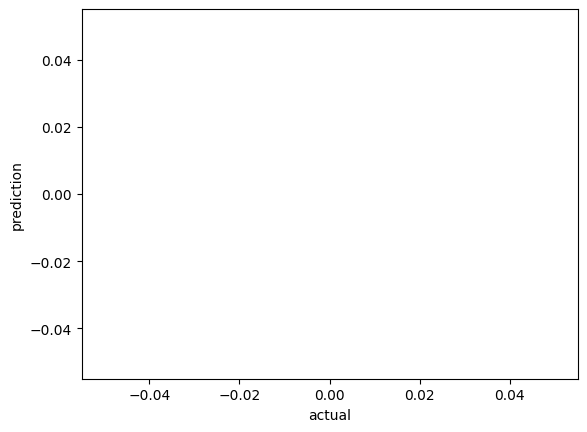

In [ ]:
y_pred = np.expm1(stacked_model.predict(X_test))
y_pred[0:25]

plt.scatter(Y_test, y_pred);
plt.xlabel("actual")

plt.ylabel("prediction")
plt.show()

In [ ]:
stacked_score_train = mean_squared_error(Y_train, stacked_model.predict(X_train))
print(f' mean_squared_error score of stacked models on full train data: {stacked_score_train}')

stacked_score_test = mean_absolute_error(Y_test, stacked_model.predict(X_test))
print(f' mean_absolute_error of stacked models on full test data: {stacked_score_test}')

 mean_squared_error score of stacked models on full train data: 3564343152.1680093
 mean_absolute_error of stacked models on full test data: 63625.65450878982


In [ ]:
X.shape

(6435, 10)

**Let's Use the Deep Learning Network For The Same Prediction**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Defining the input shape. What's the number of features in the training data(X_train)
input_shape = [X_train.shape[1]]

# Creating a Sequential model which has a linear stack of layers.
# The layers consists of BatchNormalization, Dense (fully connected) layer with 8
# units and ReLU activation, Dropout 30% of the neurons during training to
# prevent overfitting. Then BatchNormalization normalizes the data again.
# Then another dense layer with 24 units and ReLU activation, and a final
# dense layer with 10 units (no activation function, so it's linear.)
model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(8 ,activation= 'relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(24, activation = 'relu'),
    layers.Dense(10 )
])

# Compiling the model with mse, Adam optimizer and mean squared error
model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics = ['mean_squared_error']
)

# Defining an Early Stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.01,
    restore_best_weights=True,
)


# Training the model
history = model.fit(
    X_train, Y_train,
    validation_split= 0.2,
    batch_size=25,
    epochs=1000,
    callbacks=[early_stopping]
)


Epoch 1/1000
124/124 [==============================] - 3s 5ms/step - loss: 1396149452800.0000 - mean_squared_error: 1396149452800.0000 - val_loss: 1416125612032.0000 - val_mean_squared_error: 1416125612032.0000
Epoch 2/1000
124/124 [==============================] - 0s 3ms/step - loss: 1396138180608.0000 - mean_squared_error: 1396138180608.0000 - val_loss: 1416107917312.0000 - val_mean_squared_error: 1416107917312.0000
Epoch 3/1000
124/124 [==============================] - 0s 3ms/step - loss: 1396082081792.0000 - mean_squared_error: 1396082081792.0000 - val_loss: 1415991263232.0000 - val_mean_squared_error: 1415991263232.0000
Epoch 4/1000
124/124 [==============================] - 0s 3ms/step - loss: 1395905921024.0000 - mean_squared_error: 1395905921024.0000 - val_loss: 1415594901504.0000 - val_mean_squared_error: 1415594770432.0000
Epoch 5/1000
124/124 [==============================] - 0s 3ms/step - loss: 1395552813056.0000 - mean_squared_error: 1395552813056.0000 - val_loss: 1414

<Axes: >

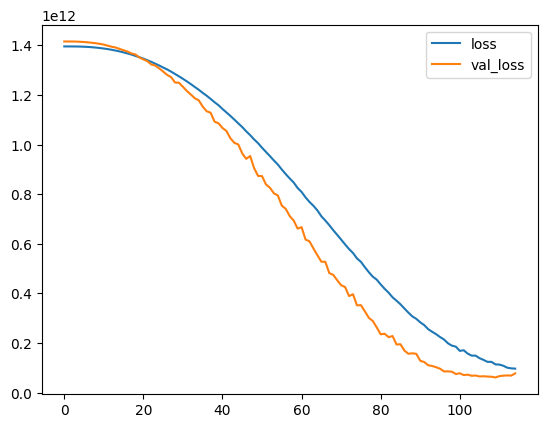

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [ ]:
mse, mae = model.evaluate(X_test, Y_test)
print(f'mean square error: {mse}')
print(f'mean absolute error: {mae}')

81/81 [==============================] - 1s 7ms/step - loss: 71291904000.0000 - mean_squared_error: 71291904000.0000
mean square error: 71291904000.0
mean absolute error: 71291904000.0
